## Goal : Extract the evolution of the number of toggles for the project kops

Import

In [1]:
import os
import regex as re
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import json

#### Before running the notebook

We extract all the versions of the featureflag/featureflag.go file with the answer of Nathan Arthur here : 
 https://stackoverflow.com/questions/12850030/git-getting-all-previous-version-of-a-specific-file-folder
 
We changed the directory to ../kops_change i.e. the line
 
 EXPORT_TO=/tmp/all_versions_exported
 
 becomes

 EXPORT_TO=../kops_changes/


#### If it worked, you should have a list of files in the ../kops_changes/ directory

In [2]:
kops_dir =  "../kops_changes/"

kops_files = [kops_dir+k for k in os.listdir(kops_dir)]

# 1. we count the number of FT

# we search for this type of expression (edit: not working for 2016-12-26): 
# New("DNSPreCreate", Bool(true)) 
# because each time it is in the code, a feature toggle is defined 
# NB : 'Bool' because this part is not in the definition of the constructor New
# we are sure to only count the feature toggles
exp = "[N|n]ew.*,*Bool*"

def extract_nb_ft(file_path):
    # input : a file path to a version of the feature toggle file
    # output : the number of feature toggles in the file
    with open(file_path, 'r') as f:
        m = re.findall(exp, f.read())
    return len(m)

# 2. we extract the date (usable as timestamp)

def extract_date(file_path):
    # input : the path of the file 
    # e.g. 0001.26-Oct-2021.46c1c24b48572d74fb582e1e5a62552c39409685.featureflag.go
    # output : the date "26-Oct-2021"
    return file_path.split(".")[3]

months = dict()

writen_monthes = pd.Series([extract_date(kf).split('-')[1] for kf in kops_files]).unique()
# writen_monthes
# ['Jun', 'Oct', 'Sep', 'May', 'Jan', 'Aug', 'Dec', 'Apr', 'Jul', 'Feb', 'Nov', 'Mar']
values = [6, 10, 9, 5, 1, 8, 12, 4, 7, 2, 11, 3]

for index_month in range(len(writen_monthes)):
    wm = writen_monthes[index_month]
    months[wm] = values[index_month]

def extract_stamp(kf):
    # input : the path of the file 
    # e.g. 0001.26-Oct-2021.46c1c24b48572d74fb582e1e5a62552c39409685.featureflag.go
    # output : a timestamp
    d = extract_date(kf).split('-')
    # class datetime.date(year, month, day)
    return datetime.date(int(d[2]), months[d[1]], int(d[0]))

# test 1. and 2. with a randomly chosen file
kf = kops_files[np.random.randint(len(kops_files))]

print("File :",kf)
print("Stamp :",extract_stamp(kf))
print("Number of FTs :",extract_nb_ft(kf))

File : ../kops_changes/0086.2-Oct-2021.34b982f87c78a56f5824c4ccf4ad87fe9cf5796f.featureflag.go
Stamp : 2021-10-02
Number of FTs : 24


#### Plot results

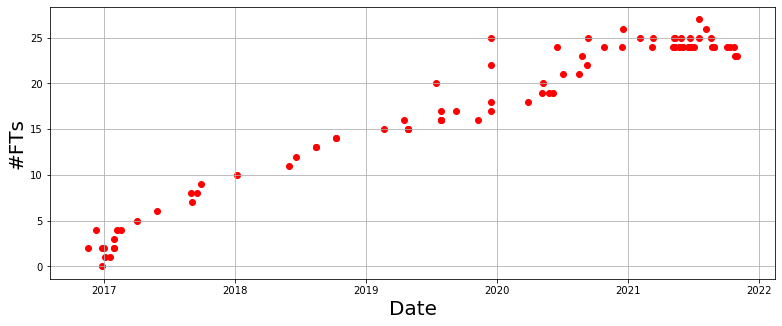

In [3]:
df = pd.DataFrame([[extract_stamp(kf) for kf in kops_files], 
                  [extract_nb_ft(kf) for kf in kops_files]]).transpose()
df.columns = ["Date", "#FTs"]
df = df.sort_values(by=["Date"])

plt.figure(figsize=(13, 5))
plt.grid()
plt.scatter(df["Date"], df["#FTs"], color = "red")
plt.ylabel("#FTs", size =20)
plt.xlabel("Date", size =20)
plt.show()

### Add releases & tags

We download the releases of kops thanks to postman and store them in a file ../kops_releases.json:

call https://api.github.com/repos/kubernetes/kops/releases

?per_page=100&page=1

and

?per_page=100&page=2

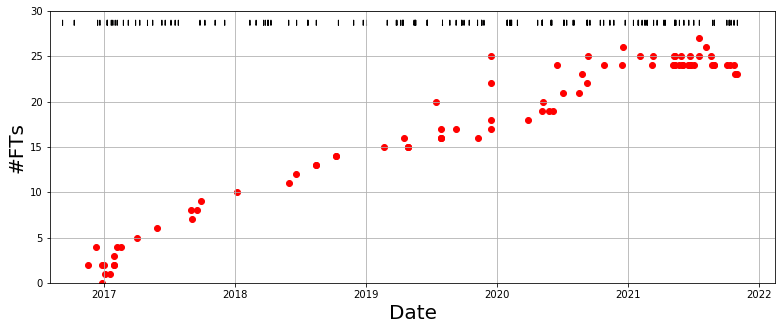

In [7]:
releases = json.load(open("../kops_releases.json"))

date_release = [datetime.datetime.strptime(r["published_at"], "%Y-%m-%dT%H:%M:%SZ")
                for r in releases]
name_release = [r["name"] for r in releases]


plt.figure(figsize=(13, 5))
plt.grid()
plt.scatter(df["Date"], df["#FTs"], color = "red")
for index_release in range(len(date_release)):
    plt.arrow(date_release[index_release], 29, 0, 
                 -0.5, head_width=0.5, head_length=0.1)
plt.ylim(0, 30)
plt.ylabel("#FTs", size =20)
plt.xlabel("Date", size =20)
plt.savefig("../evolution_fts_kops.png", dpi=300)
plt.show()

In [5]:
len(releases)

131